# Quantum Bits

## Qubit

The fundamental unit of classical information storage, processing and transmission is the bit. Analogously, we define its quantum counterpart, a quantum bit or simply the qubit. Below we define a qubit in CUDA-Q. 

In [1]:
import cudaq

# Build a cudaq kernel.


@cudaq.kernel
def kernel():
    # Allocate a single qubit to the kernel.
    qubit = cudaq.qubit()

Classcial bits are transistor elements whose states can be altered to perform computations. Similarly qubits too have physical relizations within superconducting materials, ion-traps and photonic systems. We shall not concern ourselves with specific qubit architectures but rather think of them as systems which obey the laws of quantum mechanics and the mathematical language physicists have developed to describe the theory: linear algebra.

Information storage scales linearly if bits have a single state. Access to multiple states, namely a 0 and a 1 allows for information encoding to scale logarithmically. Similarly we define a qubit to have the states $\ket{0}$ and $\ket{1}$ in Dirac notation where: 

$$\ket{0} = \begin{bmatrix} 1 \\ 0 \\ \end{bmatrix}$$
$$\ket{1} = \begin{bmatrix} 0 \\ 1 \\ \end{bmatrix}$$ 

## Pauli X gate

We can manipulate the state of the qubit via quantum gates. The pauli X gate allows us to flip the state of the qubit: 

$$ X \ket{0} = \ket{1} $$ 

$$ \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} 1 \\ 0 \\ \end{bmatrix} = \begin{bmatrix} 0 \\ 1 \\ \end{bmatrix} $$

In [2]:
@cudaq.kernel
def kernel():
    # A single qubit initialized to the ground/ zero state.
    qubit = cudaq.qubit()

    # Apply the pauli x gate to the qubit.
    x(qubit)

    # Measurement operator.
    mz(qubit)


# Sample the qubit for 1000 shots to gather statistics.
result = cudaq.sample(kernel, shots_count=1000)

print(result)

{ 1:1000 }



## Superpositions & Measurements

We have explored the 2 states accessible to us via a qubit. In fact, quantum theory allows one to explore linear combinations of states namely superpositions: 

$$  \ket{\psi} = \alpha\ket{0} + \beta\ket{1} $$ 

where $\alpha$ and $\beta$ $\in \mathbb{C}$. It is important to note that this is still the state of one qubit even though $\ket{\psi}$ has 2 kets. 

Quantum theory is probabilistic and hence requires statistical inference to derive observations. Prior to measurement, the state of a qubit is all possible combinations of $\alpha$ and $\beta$ and upon measurement, wavefunction collapse yields either a classical 0 or 1. 

The mathematical theory devised to explain quantum phenomena tells us that the probability of observing the qubit in the state $\ket{0}$/ $\ket{1}$ yielding a classical 0/ 1 is $\lvert \alpha \rvert ^2$ / $\lvert \beta \rvert ^2$. The theory has been verified experimentally countless times and we shall verify it once more below. 

The hadamard gate allows us to put the qubit in an equal superposition state:

$$ H \ket{0} =  \tfrac{1}{\sqrt{2}} \ket{0} + \tfrac{1}{\sqrt{2}} \ket{1}  \equiv \ket{+}$$

$$\tfrac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \begin{bmatrix} 1 \\ 0 \\ \end{bmatrix} = \tfrac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ \end{bmatrix} + \tfrac{1}{\sqrt{2}} \begin{bmatrix} 0 \\ 1 \\ \end{bmatrix}. $$

The probability of finding the qubit in the 0 / 1 state is hence $\lvert \tfrac{1}{\sqrt{2}} \rvert ^2 = \tfrac{1}{2}$. Lets verify this with some code: 

In [3]:
@cudaq.kernel
def kernel():
    # A single qubit initialized to the ground/ zero state.
    qubit = cudaq.qubit()

    # Apply hadamard gate to single qubit to put it in equal superposition.
    h(qubit)

    # Measurement operator.
    mz(qubit)


result = cudaq.sample(kernel, shots_count=1000)

print(result)

{ 0:502 1:498 }



Quantum theory is statistical and statistical accuracy increases with sampling. Above we see how with a 1000 shots, the result 0 / 1 is yielded roughly 50% of the times as predicted by the postulate stated above thus proving the theory. 

For completeness: 

$$ H \ket{1} =  \tfrac{1}{\sqrt{2}} \ket{0} - \tfrac{1}{\sqrt{2}} \ket{1}  \equiv \ket{-}$$


## Qubit visualizations


What are the possible states our qubit can be in and how can we build up a visual cue to help us make sense of quantum states and their evolution?

We know our qubit can have 2 distinct states: $\ket{0}$ and $\ket{1}$. Maybe we need a 1 dimensional line whose verticies can represent each of the aforementioned states. 

We also know that qubits' can be in an equal superposition states: $\ket{+}$ and $\ket{-}$. This now forces us to extend our 1-D line to a 2-D cartesian coordinate system. 

Later, we will learn the existence of states that can be represented with $\ket{+i}$ and $\ket{-i}$, this calls for a 3-D extension. 

It turns out that a sphere is able to depict all the possible states of a single qubit as shown in figure below: 

<img src="images/Bloch_sphere.png" alt="Bloch Sphere" width="300" height="300">



Let us try to showcase the functionality to render such a 3D representation with CUDA-Q.

First, let us define a single-qubit kernel that returns a different state each time. This kernel uses random rotations.

Note: CUDA-Q uses the [QuTiP](https://qutip.org) library to render Bloch spheres. The following code will throw an error if QuTiP is not installed. 

In [4]:
# install `qutip` in the current Python kernel. Skip this if `qutip` is already installed. 
# `matplotlib` is required for all visualization tasks.
# Make sure to restart your kernel if you execute this! 
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

# The '\' before the '>' operator is so that the shell does not misunderstand
# the '>' qualifier for the bash pipe operation.

import sys

try:
    import matplotlib.pyplot as plt
    import qutip
except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5
    print("\nNew libraries have been installed. Please restart your kernel!")

In [5]:
import cudaq
import numpy as np

# Try with density matrix by uncommenting line below
# cudaq.set_target("density-matrix-cpu")

@cudaq.kernel
def kernel(angles:np.ndarray):
    qubit = cudaq.qubit()
    rz(angles[0],qubit)
    rx(angles[1],qubit)
    rz(angles[2],qubit)

Next, we instantiate a random number generator, so we can get random outputs. We then create 4 random single-qubit states by using `cudaq.add_to_bloch_sphere()` on the output state obtained from the random kernel.

In [6]:
rng = np.random.default_rng()
blochSphereList = []
for _ in range(4):
    angleList = rng.random(3)*2*np.pi
    sph = cudaq.add_to_bloch_sphere(cudaq.get_state(kernel,angleList))
    blochSphereList.append(sph)

We can display the spheres with `cudaq.show()`. Show the first sphere:

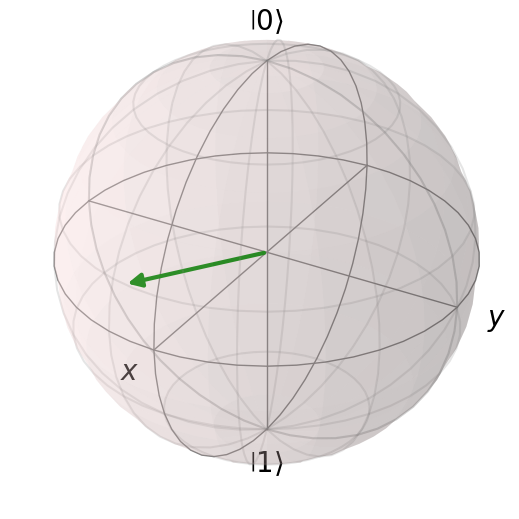

In [7]:
cudaq.show(blochSphereList[0])

We can also show multiple Bloch spheres side by side - simply set the `nrows` and `ncols` in the call to `cudaq.show()` accordingly. Make sure to have more spaces than spheres in your list, else it will throw an error! Let us show two spheres in a row:

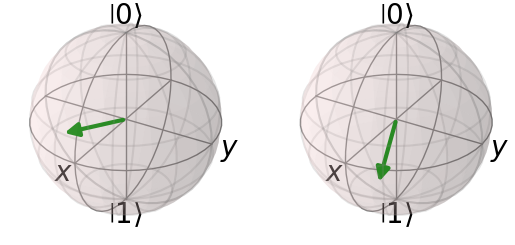

In [8]:
cudaq.show(blochSphereList[:2], nrows=1, ncols=2)

We can show them in a column too, if we want! Simply set the `nrows = 2` and `ncols = 1`.

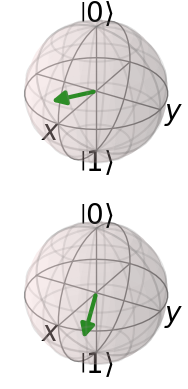

In [9]:
cudaq.show(blochSphereList[:2], nrows=2, ncols=1)

Can we show the entire list of 4 Bloch spheres we created? Absolutely!

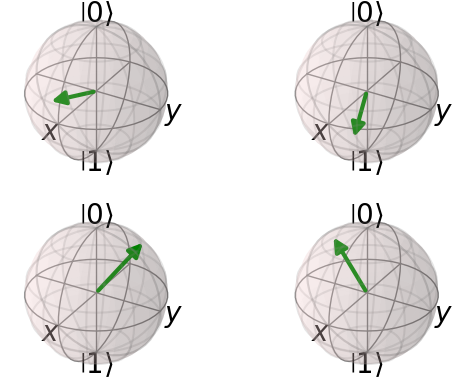

In [10]:
cudaq.show(blochSphereList[:], nrows=2, ncols=2)

What if we had to add multiple vectors to a single Bloch sphere? CUDA-Q uses the [QuTiP](https://www.qutip.org) toolbox to construct Bloch spheres. We can then add multiple states to the same Bloch sphere by passing the sphere object as an argument to `cudaq.add_to_bloch_sphere()`.

In [15]:
import qutip 
rng = np.random.default_rng()
blochSphere = qutip.Bloch() 
for _ in range(10):
    angleList = rng.random(3)*2*np.pi
    sph = cudaq.add_to_bloch_sphere(cudaq.get_state(kernel,angleList), blochSphere)

This created a single Bloch sphere with 10 random vectors. Let us see how it looks.

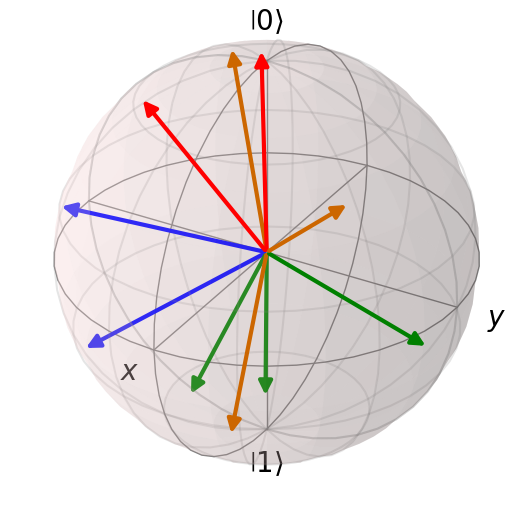

In [16]:
blochSphere.show()

## Gate linearity

Lets manipulate a single qubit: 


1. $$  X  \ket{0} = \ket{1}  $$

2. $$  X  \ket{1} = \ket{0}  $$

And more generally, for a qubit in a superposition state, quantum gates act linearly:

 $$   X (\alpha\ket{0} + \beta\ket{1}) = \alpha\ket{1} + \beta\ket{0} $$ 

It is important to note that states such as $\alpha\ket{0} + \beta\ket{1}$ reference a single qubit in a superposition state. Although we have two kets, they both represent a superposition state of one qubit. We shall explore multiple qubits and their notation in the next chapter. 



## Gate unitarity 

As we evolve quantum states via quantum gates, the normalization condition requires that the sum of modulus squared of amplitudes must equal 1 at all times: 

$$  \ket{\psi} = \alpha\ket{0} + \beta\ket{1},          |\alpha|^2 + |\beta|^2 = 1. $$



This is to adhere to the conservation of probabilities which translates to a constraint on types of quantum gates we can define. 

For a general quantum state $\ket{\psi}$, upholding the normalisation condition requires quantum gates to be unitary, that is $U^{\dagger}U = U^{*^{T}}U = \mathbb{I}$.



## Single qubit gates

Below we summarise a few single qubit gates and their effects on quantum states:


$$ X \equiv \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}, \hspace{1cm} X(\alpha\ket{0} + \beta\ket{1}) = \alpha\ket{1} + \beta\ket{0} \hspace{1cm}  $$

$$ Z \equiv \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}, \hspace{1cm} Z(\alpha\ket{0} + \beta\ket{1}) = \alpha\ket{0} - \beta\ket{1}  $$

$$ H \equiv \tfrac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}, \hspace{1cm} H(\alpha\ket{0} + \beta\ket{1}) = \alpha\tfrac{\ket{0}+\ket{1}}{\sqrt{2}} + \beta\tfrac{\ket{0}-\ket{1}}{\sqrt{2}}  $$



